# PHYS 581 Final Project - Image Classification using TensorFlow

In this project, we will utilize a neural network in order to classify images from the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html). The dataset consists of 60,000 total images of airplanes, automobiles, cats, dogs, and other objects. The main goal will be to explore how the preprocessing of the images will lend itself to better or worse classification by the neural network.

## The Data

The original a data is supplied in 6 batches, 5 training batches each with 10,000 images and a test batch of 10,000 images. These batches come in the form of a (10000 x 3072) dimensional tensor expressed in a numpy array. As stated in the [CIFAR-10/CIFAR-100 dataset](https://www.cs.toronto.edu/~kriz/cifar.html), the row vector, (3072) represents a color image of 32x32 pixels. Thus we are required to reshape the row vector, (3072), into a (32 x 32 x 3) tensor where the third dimension is the three RGB color channels. Furthermore, we will merge all 5 training batches in order to supply the neural network with a large training data set of 50,000 images.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [2]:
#C:\\Users\\Sigi\\OneDrive\\PHYS 581\\cifar-10-batches-py

def load_cfar10_batch(batch_id):
    """
    Loads CIFAR-10 dataset from directory and reshapes for use in matplotlib and tensorflow neural networks.
    """
    with open('C:\\Users\\Sigi\\OneDrive\\PHYS 581\\cifar-10-batches-py\\' + str(batch_id), mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')
    
    data = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    labels = batch['labels']
        
    return data, labels

def create_raw_data():
    """
    Creates the full CIFAR-10 dataset and merges all training batches.
    """
    batch_data1, batch_labels1 = load_cfar10_batch('data_batch_1')
    batch_data2, batch_labels2 = load_cfar10_batch('data_batch_2')
    batch_data3, batch_labels3 = load_cfar10_batch('data_batch_3')
    batch_data4, batch_labels4 = load_cfar10_batch('data_batch_4')
    batch_data5, batch_labels5 = load_cfar10_batch('data_batch_5')

    train_images = np.concatenate((batch_data1, batch_data2, batch_data3, batch_data4, batch_data5), axis=0)
    train_labels = np.concatenate((batch_labels1, batch_labels2, batch_labels3, batch_labels4, batch_labels5), axis=0)

    test_images, test_labels = load_cfar10_batch('test_batch')
    
    return train_images, train_labels, test_images, test_labels

In [3]:
train_images, train_labels, test_images, test_labels = create_raw_data()

The label data is a list of numbers in the range 0-9 corresponding to each of the 10 classes in CIFAR-10.
* **0: airplaine**
* **1: automobile**
* **2: bird**
* **3: cat**
* **4: deer**
* **5: dog**
* **6: frog**
* **7: horse**
* **8: ship**
* **9: truck**

In [4]:
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'] 

Let us display the first 9 images in the training data set.

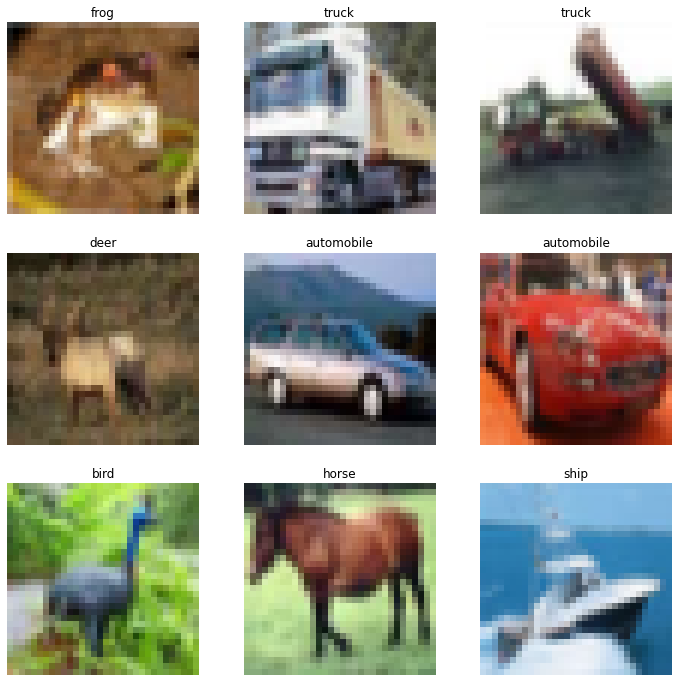

In [5]:
fig = plt.figure(figsize=(12,12))
for i in range(9):
    fig.add_subplot(3,3,i+1)
    plt.imshow(train_images[i])
    plt.title(label_names[train_labels[i]])
    plt.axis('off')

## Preprocessing Functions

Here we define all of our preprocessing functions. These will be implemented individually in order to measure individual effects on the neural networks ability to perform image classification.

Let us also define a function to save the processed images.

In [6]:
def save_preprocess(data, labels, filename):
    """
    Creates a file of images and corresponding labels.
    """
    labels = encode(labels)
    pickle.dump((data, labels), open(filename, 'wb'))

### One-Hot Encoding

When applying a neural network for image classification, the network outputs probabilities of an image falling under a each class. Thus our model will output a vector of size 10 since we have 10 image classes, where each element is the probability of the image pertaining to a class. As such, we must reform our input label data to also be a vector of size 10 where the label of an image has a probability of 1 for its corresponding class and 0 for all else.

In [7]:
def encode(x):
    """
    Converts image labels to a probability vector for use in a neural network.
    """
    y = np.zeros((len(x), 10))
    for i,val in enumerate(x):
        y[i][val] = 1
    return y

In [8]:
train_labels = encode(train_labels)
test_labels = encode(test_labels)

### Min-Max Normalization

The raw image data contains a value ranging from 0-255 for each pixel color channel. When these values are passed through the activation function, the units output may not vary as much as its input varies. When units saturate, components of the gradient are driven to zero. If too many units approach saturation, the gradient becomes small and learning becomes exceedingly slow. For example, the sigmoid activation function takes an input value and outputs a new value ranging from 0 to 1. When the input value is large, the output value easily reaches the maximum. So in the case of our data we can see that we would saturate around 1 and this effect takes place.

On the other hand, the ReLU activation function takes an input value and outputs a new value ranging from 0 to infinity. Thus ReLU may output very large values for our data and in the backpropagation process, could lead to an exploding gradient which results in unstable learning by the neural network.

In order to avoid both of these cases, we map our input pixel values to the 0-1 range by performing a min-max normalization given by

$$x' = \frac{x-min(x)}{max(x)-min(x)} $$


In [9]:
def normalize(x):
    """
    Creates a min-max normalized array of any input array x.
    """
    min_val = np.min(x)
    max_val = np.max(x)
    y = (x-min_val) / (max_val-min_val)
    return y

### Grayscale Images

Since many of the objects in our dataset come in a variety of colors, many of which have large overlap, it may confuse the neural network in its effort to classify images. As such it may or may not be useful to remove color information in the case it does not aid the neural network in image classification.

In [10]:
def grayscale(x):
    """
    Converts a single image x to grayscale by taking the mean of the RGB channels.
    """
    return np.mean(x, axis=2)

def grayscale_data(x):
    """
    Converts an array of input images x to grayscale.
    """
    y = np.zeros((len(x),32,32))
    for i,img in enumerate(x):
        y[i] = grayscale(img)
    return y

(-0.5, 31.5, 31.5, -0.5)

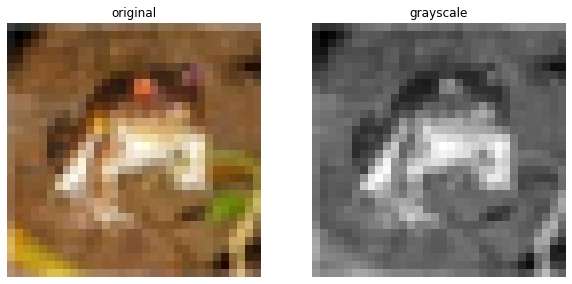

In [11]:
fig = plt.figure(figsize=(10,10))
fig.add_subplot(1,2,1)
plt.imshow(train_images[0])
plt.title('original')
plt.axis('off')

fig.add_subplot(1,2,2)
plt.imshow(grayscale(train_images[0]), cmap='gray')
plt.title('grayscale')
plt.axis('off')

### Gaussian-Blur

A Gaussian blur is an image filter which reduces image noise and detail. Most of these filters smooth the whole image, which in our case may not be so useful since the neural network relies heavily on edge detection. As such, we utilize the bilateral filter which is a non-linear, edge-preserving and noise-reducing smoothing filter.

In [12]:
import cv2

def bilateral_filter(x):
    """
    Applies the Gaussian bilateral filter to an array of images.
    """
    y = x.copy()
    for i,arr in enumerate(x):
        y[i] = cv2.bilateralFilter(arr, 3, 75, 15)
    return y

(-0.5, 31.5, 31.5, -0.5)

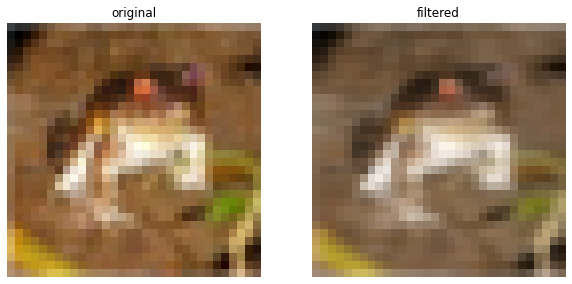

In [13]:
fig = plt.figure(figsize=(10,10))
fig.add_subplot(1,2,1)
plt.imshow(train_images[0])
plt.title('original')
plt.axis('off')

fig.add_subplot(1,2,2)
plt.imshow(bilateral_filter(train_images[0]))
plt.title('filtered')
plt.axis('off')

### Principal Component Analysis

Principal component analysis is a dimensionality reduction technique which removes correlation among variables. It does so by translation and rotation of the original axes and projecting data onto new axes where the direction of projection is determined using eigenvalues and eigenvectors. The first few transformed features (termed as Principal Components) are rich in information, whereas the last features contain mostly noise with negligible information in them. The images are projected onto these principal components in order to compress the image data. This will likely not be a useful preprocessing step since image information is lost in the process, but we will test the effects to make sure.

In [14]:
from sklearn.decomposition import PCA

def PCA_img(img, k):
    """
    Calculates k principal components of an image and projects back onto them.
    """
    pca = PCA(k)
    
    red = img[:,:,0]
    green = img[:,:,1]
    blue = img[:,:,2]

    red_transformed = pca.fit_transform(red)
    red_inverted = pca.inverse_transform(red_transformed)
    green_transformed = pca.fit_transform(green)
    green_inverted = pca.inverse_transform(green_transformed)
    blue_transformed = pca.fit_transform(blue)
    blue_inverted = pca.inverse_transform(blue_transformed)

    compressed_img = (np.dstack((red_inverted, green_inverted, blue_inverted))).astype(np.uint8)
    
    return compressed_img

def principal_component_analysis(x, k=32):
    """
    Converts an array of input images to their principal component projected counterparts.
    """
    y = x.copy()
    for i,img in enumerate(y):
        y[i] = PCA_img(img, k)
    return y

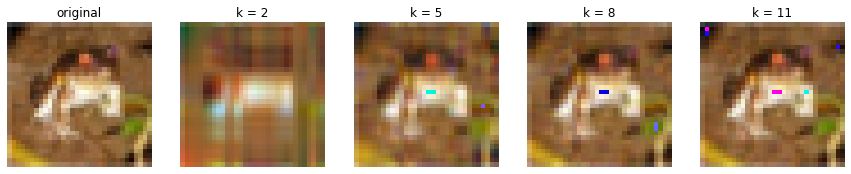

In [15]:
fig = plt.figure(figsize=(15,3))
fig.add_subplot(1,5,1)
plt.imshow(train_images[0])
plt.title('original')
plt.axis('off')

for i in range(4):
    fig.add_subplot(1,5,i+2)
    plt.imshow(PCA_img(train_images[0],3*i+2))
    plt.title('k = ' + str(3*i+2))
    plt.axis('off')

### Auto-Encoding

Autoencoders are useful for denoising data and dimensionality reduction of data. In general, an autoencoder is a system composed of two parts; the encoder compresses input data and the decoder attempts to reconstruct the original data using the compressed data from the encoder. This is a sort of non-linear form of principal component analysis, where the encoder is tasked with identifying 'principal components' which contain a significant amount of the information in the input data and the decoder is tasked with projecting the 'principal components' back onto the original data space. Through this process the autoencoder should identify the main features in the images and reduce image noise.

In [32]:
import tensorflow
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Flatten, Dense, Reshape, Input, InputLayer

In [33]:
def gen_autoencoder(img, compression_size=32):
    """
    Generates an autoencoder model with single encoder and decoder layers.
    """
    encoder = Sequential(name='Encoder')
    encoder.add(InputLayer(img.shape, name='inputs'))
    encoder.add(Flatten(name='flatten'))
    encoder.add(Dense(compression_size, activation='relu', name='encoder_layer'))
    
    decoder = Sequential(name='Decoder')
    decoder.add(InputLayer((compression_size,), name='inputs'))
    decoder.add(Dense(np.prod(img.shape), activation='sigmoid', name='decoder_layer'))
    decoder.add(Reshape(img.shape, name='reshape'))
    
    input_img = Input(img.shape, name='input')
    compressed = encoder(input_img)
    reconstructed = decoder(compressed)

    autoencoder = Model(input_img, reconstructed, name='AutoEncoder')
    autoencoder.compile(loss='mse', optimizer='adamax')
    
    return autoencoder, encoder, decoder

In [34]:
autoencoder, encoder, decoder = gen_autoencoder(train_images[0], compression_size=100)
encoder.summary()
decoder.summary()
autoencoder.summary()

Model: "Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
encoder_layer (Dense)        (None, 100)               307300    
Total params: 307,300
Trainable params: 307,300
Non-trainable params: 0
_________________________________________________________________
Model: "Decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_layer (Dense)        (None, 3072)              310272    
_________________________________________________________________
reshape (Reshape)            (None, 32, 32, 3)         0         
Total params: 310,272
Trainable params: 310,272
Non-trainable params: 0
_________________________________________________________________
Model: "AutoEncoder"
_________

In [35]:
train_images = normalize(train_images)
test_images = normalize(test_images)
results = autoencoder.fit(train_images, train_images, validation_data=(test_images, test_images), epochs=30, verbose=0)
encoded_imgs = encoder.predict(train_images)
decoded_imgs = decoder.predict(encoded_imgs)

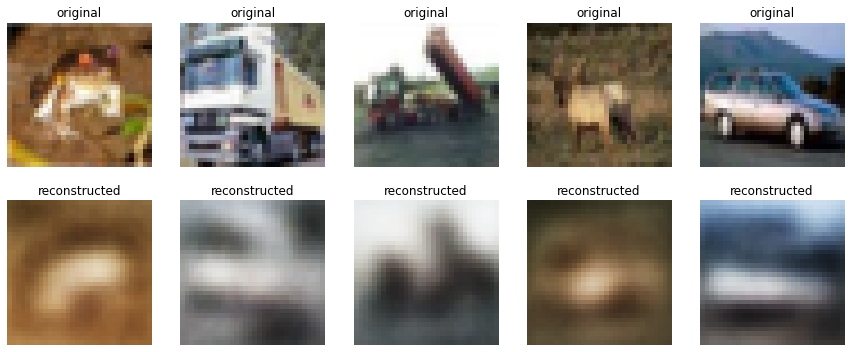

In [36]:
fig = plt.figure(figsize=(15,6))

n=5
for i in range(n):
    fig.add_subplot(2,n,i+1)
    plt.imshow(train_images[i])
    plt.title('original')
    plt.axis('off')
    
    fig.add_subplot(2,n,i+n+1)
    plt.imshow(decoded_imgs[i])
    plt.title('reconstructed')
    plt.axis('off')

Unfortunately, our simple implementation of an autoencoder fails to reconstruct images well enough to test in the neural network for image classification. We could implement a more complicated system, but given the rather large computation times, even for the simple model, we decided to not pursue more acceptable outcomes.

## TensorFlow Neural Network

We will implement a simple neural network with 3 dense layers to perform our testing of the various preprocessing steps towards image classification. The dense layers will use the ReLU activation function and our classifying layer will use the softmax activation function which returns a classification probability vector. The model's loss function will be the categorical crossentropy.

In [20]:
import tensorflow
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout, InputLayer
from keras.optimizers import SGD

In [21]:
def gen_model(img):
    """
    Generates a neural network with 3 fully connected layers for image classification.
    """
    model = keras.Sequential(name='SimpleImageClassifier')
    model.add(InputLayer(img.shape, name='input'))
    model.add(Flatten(input_shape=img.shape, name='flatten'))
    model.add(Dense(256, activation='relu', name='layer1'))
    model.add(Dense(128, activation='relu', name='layer2'))
    model.add(Dense(64, activation='relu', name='layer3'))
    model.add(Dense(10, activation='softmax', name='outputs'))
    model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.01, momentum=0.9), metrics=['accuracy'])
    return model

In [22]:
train_images, train_labels, test_images, test_labels = create_raw_data()
model = gen_model(train_images[0])
model.summary()

Model: "SimpleImageClassifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
layer1 (Dense)               (None, 256)               786688    
_________________________________________________________________
layer2 (Dense)               (None, 128)               32896     
_________________________________________________________________
layer3 (Dense)               (None, 64)                8256      
_________________________________________________________________
outputs (Dense)              (None, 10)                650       
Total params: 828,490
Trainable params: 828,490
Non-trainable params: 0
_________________________________________________________________


In [23]:
def plot_results(results):
    """
    Plots the loss and accuracy results of training a neural network model.
    """
    fig, axes = plt.subplots(2, 1, figsize=(10,8))

    plt.sca(axes[0])
    plt.title('Loss')
    plt.plot(results.history['loss'], label='train')
    plt.plot(results.history['val_loss'], label='test')
    plt.legend(loc=0)
    #plt.yscale('log')
    plt.ylabel('loss')

    plt.sca(axes[1])
    plt.title('Accuracy')
    plt.plot(results.history['accuracy'], label='train')
    plt.plot(results.history['val_accuracy'], label='test')
    plt.legend(loc=0)
    #plt.yscale('log')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    
    plt.show()

### Classifying Original Images

The only preprocessing step for the original data is to normalize. Let us establish the benchmarks for our model.

In [24]:
train_images, train_labels, test_images, test_labels = create_raw_data()
train_images = normalize(train_images)
test_images = normalize(test_images)
train_labels = encode(train_labels)
test_labels = encode(test_labels)

Training accuracy: 0.6368600130081177
Testing accuracy: 0.5098000168800354


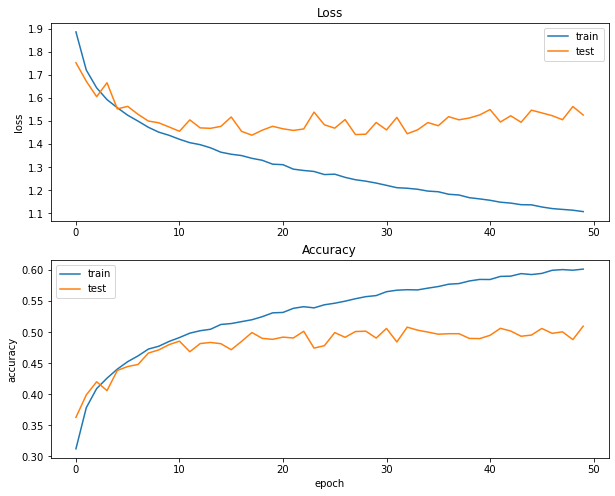

In [25]:
model = gen_model(train_images[0])
results = model.fit(train_images, train_labels, validation_data=(test_images, test_labels), epochs=50, verbose=0)

print('Training accuracy:', model.evaluate(train_images, train_labels, verbose=0)[1])
print('Testing accuracy:', model.evaluate(test_images, test_labels, verbose=0)[1])
plot_results(results)

The benchmark made by our model on the original images is a testing accuracy of **50.98%**.

### Classifying Grayscale Images

In [28]:
train_images, train_labels, test_images, test_labels = create_raw_data()
gray_train_images = normalize(grayscale_data(train_images))
gray_test_images = normalize(grayscale_data(test_images))
train_labels = encode(train_labels)
test_labels = encode(test_labels)

Training accuracy: 0.5776200294494629
Testing accuracy: 0.4194999933242798


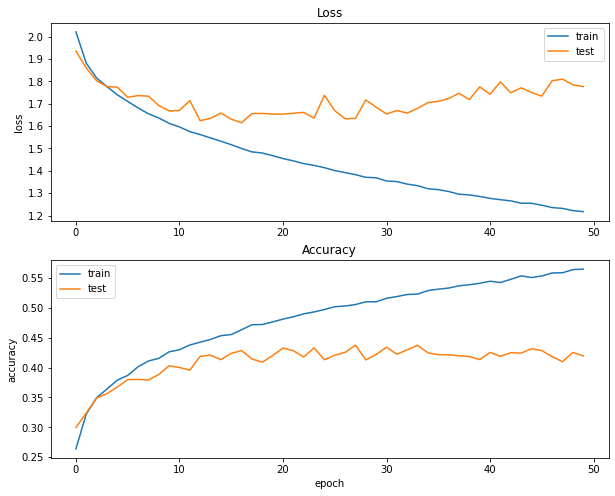

In [29]:
model = gen_model(gray_train_images[0])
results = model.fit(gray_train_images, train_labels, validation_data=(gray_test_images, test_labels), epochs=50, verbose=0)

print('Training accuracy:', model.evaluate(gray_train_images, train_labels, verbose=0)[1])
print('Testing accuracy:', model.evaluate(gray_test_images, test_labels, verbose=0)[1])
plot_results(results)

Removing color data from the images leads our model to achieve a **41.94%** testing accuracy which is **82.27%** of the benchmark.

### Classifying Filtered Images

In [30]:
train_images, train_labels, test_images, test_labels = create_raw_data()
filtered_train_images = normalize(bilateral_filter(train_images))
filtered_test_images = normalize(bilateral_filter(test_images))
train_labels = encode(train_labels)
test_labels = encode(test_labels)

Training accuracy: 0.5989000201225281
Testing accuracy: 0.48969998955726624


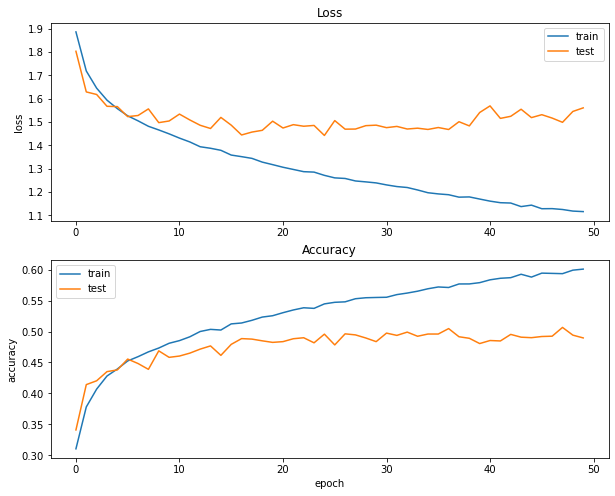

In [31]:
model = gen_model(train_images[0])
results = model.fit(filtered_train_images, train_labels, validation_data=(filtered_test_images, test_labels), epochs=50, verbose=0)

print('Training accuracy:', model.evaluate(filtered_train_images, train_labels, verbose=0)[1])
print('Testing accuracy:', model.evaluate(filtered_test_images, test_labels, verbose=0)[1])
plot_results(results)

Treating the images with the bilateral filter leads our model to achieve a **48.97%** testing accuracy which is **96.06%** of the benchmark.

### Classifying PCA Reconstructed Images

In [101]:
train_images, train_labels, test_images, test_labels = create_raw_data()
train_labels = encode(train_labels)
test_labels = encode(test_labels)

In [136]:
results = []
for k in [5,10,15,20]:
    model = gen_model(train_images[0])
    
    pca_train_images = normalize(principal_component_analysis(train_images, k=k))
    pca_test_images = normalize(principal_component_analysis(test_images, k=k))
    
    results.append(model.fit(pca_train_images, train_labels, validation_data=(pca_test_images, test_labels), epochs=50, verbose=0))
    
    print('Using k =', k, 'principal components:')
    print('\tTraining accuracy:', model.evaluate(pca_train_images, train_labels, verbose=0)[1])
    print('\tTesting accuracy:', model.evaluate(pca_test_images, test_labels, verbose=0)[1])

Using k = 5 principal components:
	Training accuracy: 0.6237599849700928
	Testing accuracy: 0.47380000352859497
Using k = 10 principal components:
	Training accuracy: 0.6274600028991699
	Testing accuracy: 0.4794999957084656
Using k = 15 principal components:
	Training accuracy: 0.6569600105285645
	Testing accuracy: 0.5065000057220459
Using k = 20 principal components:
	Training accuracy: 0.626039981842041
	Testing accuracy: 0.4991999864578247


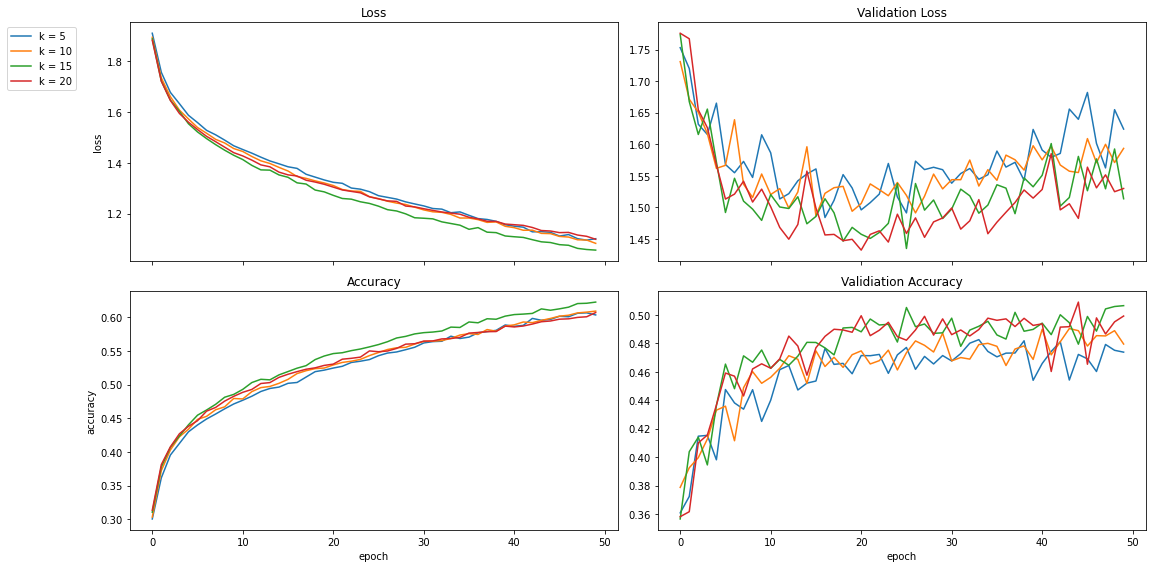

In [137]:
fig, axes = plt.subplots(2, 2, figsize=(16,8), sharex=True)

for k,res in enumerate(results):
    pca_num = 'k = ' + str(5*k+5)
    plt.sca(axes[0][0])
    plt.plot(res.history['loss'], label=pca_num)
    plt.sca(axes[0][1])
    plt.plot(res.history['val_loss'])
    
    plt.sca(axes[1][0])
    plt.plot(res.history['accuracy'])
    plt.sca(axes[1][1])
    plt.plot(res.history['val_accuracy'])

plt.sca(axes[0][0])
plt.title('Loss')
#plt.legend(loc=0)
plt.legend(bbox_to_anchor=(-0.1,1.))
plt.ylabel('loss')

plt.sca(axes[0][1])
plt.title('Validation Loss')

plt.sca(axes[1][0])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

plt.sca(axes[1][1])
plt.title('Validiation Accuracy')
plt.xlabel('epoch')

plt.tight_layout()
plt.show()

From the plots we can see that using 15 principal components yields the best results in our model. Theoretically 20 principal components should have seen an improvement in testing accuracy over 15 principal components. However, the results are close enough that we may say after 15 principal components, there is enough information in the image that we reach the limit of the model. The best testing accuracy achieved using the principal component image projection was **50.65%** which is **99.35%** of the benchmark. This result makes sense since the reconstructed image has lost some information from the original but also contains enough information that the model successfully can perform image classification to achieve scores near the benchmark.

### Classification using a Convolutional Neural Network

Convolutional layers differ from dense layers by being feed-forward and not fully connected. Their main purpose is to identify features, such as edges, which are present throughout an image. The convolution operation makes use of a kernel, which moves over each part of the image to check if the feature it is meant to detect is present. The detection is made by taking a sub-window of the image and computing the dot product between the image and the sub-window. As a result, you get a single number that represents all the values in a given window. So if a feature is present in part of an image, the dot product yields a real number with a high value and if not present, a low value. Performing this operation over the whole image results in a feature map. Furthermore, in order for the convolutional layer to be non-linear, the output of the convolution operation is summed with a bias term and passed through a non-linear activation function, typically the Rectified Linear Unit (ReLU).

Once the filter has been applied, it is a common step to reduce the dimensions of the feature map by subsampling. The most common technique for subsampling is max pooling. With this technique, we also have a kernel which moves over the image, taking the highest pixel value from a region and throwing out the rest of the pixel data in that region. Applying this technique to the feature map is a form of dimensionality reduction and can be thought of as reducing noise in the feature map, thus strengthening the identified features. This forces the network to focus on these features and makes it less likely to overfit the training data and hopefully generalize well.

The convolutional and subsampling layers act as a preprocessing of the input data before it reaches a set of fully connected layers, which then processes the feature maps for classification. Let us implement a model which utilizes convolution layers and compare the results to that of our simple model.

In [146]:
def gen_conv_model():
    """
    Generates a neural network with 2 convolutional layers and 3 fully connected layers for image classification.
    """
    model = keras.Sequential(name='ConvolutionalImageClassifier')
    model.add(InputLayer((32,32,3), name='input'))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3), name='conv1'))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', name='conv2'))
    model.add(MaxPooling2D((2, 2), name='max_pooling_1'))
    model.add(Dropout(0.2, name='dropout1'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', name='conv3'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', name='conv4'))
    model.add(MaxPooling2D((2, 2), name='max_pooling_2'))
    model.add(Dropout(0.2, name='dropout2'))
    model.add(Flatten(name='flatten'))
    model.add(Dense(64, activation='relu', name='connected1'))
    model.add(Dense(128, activation='relu', name='connected2'))
    model.add(Dense(64, activation='relu', name='connected3'))
    model.add(Dense(10, activation='softmax', name='outputs'))
    model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.01, momentum=0.9), metrics=['accuracy'])
    return model

In [147]:
model = gen_conv_model()
model.summary()

Model: "ConvolutionalImageClassifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________
conv2 (Conv2D)               (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling_1 (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout1 (Dropout)           (None, 16, 16, 32)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 16, 16, 64)        18496     
_________________________________________________________________
conv4 (Conv2D)               (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling_2 (MaxPooling2D) (None, 8,

In [150]:
train_images, train_labels, test_images, test_labels = create_raw_data()
train_images = normalize(train_images)
test_images = normalize(test_images)
train_labels = encode(train_labels)
test_labels = encode(test_labels)

Training accuracy: 0.9349600076675415
Testing accuracy: 0.7706000208854675


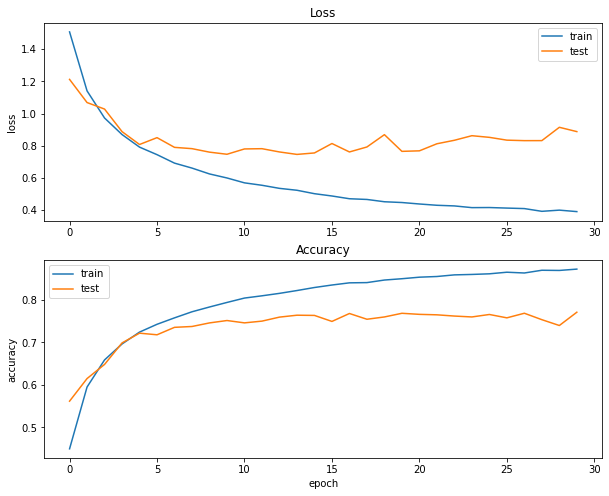

In [151]:
results = model.fit(train_images, train_labels, validation_data=(test_images, test_labels), epochs=30, verbose=0)

print('Training accuracy:', model.evaluate(train_images, train_labels, verbose=0)[1])
print('Testing accuracy:', model.evaluate(test_images, test_labels, verbose=0)[1])
plot_results(results)

Introducing 2 convolution layers to our model yields a testing accuracy of **77.06%** which is **151.16%** of the benchmark made by the simple model.

## Conclusion

What we learn from this project is that a neural network, in the case of images, prefers original data to any processed data. Removing color information yielded significantly worse results when compared to the benchmark. This tells us that color information is in fact valuable for image classification even if colors are not unique to our image classes. Applying the Gaussian bilateral filter didn't have a large detrimental effect on the models ability to classify images, but results did not improve and we're led to conclude that unfiltered data is preferred. Applying PCA to the images also did not improve results. This is likely due to the fact that PCA removes correlation among variables and we know that neural networks deal well with highly correlated information. Implementing the autoencoder as a preprocessing step would have likely yielded a similar result to PCA, where in the case of optimal image reconstruction, the model then reaches the benchmark limit. Ultimately, we learn that neural networks require the greatest amount of information available in order to optimally perform demarcation between image classes.

Furthermore, we learn that implementing convolution layers in our model can greatly improve the models ability to classify images. This tells us that instead of manually preprocessing images, it is better to allow the model to learn to obtain its own feature map of original images and perform classification based on the feature maps.